# Twitter sentiment analysis

Dataset from: http://help.sentiment140.com/for-students/ and also https://www.kaggle.com/kazanova/sentiment140 

Code **based on:** https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm - please also check this notebook for more comments to what is happening.

**Added:** inference with the trained model, scripts to download data more easily to a Colab, some tricks to shorted the time needed to train the model (results will not be the best, but they can be shown during an online session...).


*PS: there was a paper released with this dataset, check it here [TwitterDistantSupervision09.pdf](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*

## TL;DR




1.   1st we download data (from Stanford dataset of labelled Twitter data)
2.   Then we load and pre-process it (text 2 vector)
3.   Finally we make a simple model and train it!
4.   (Bonus) We show how we can interact with the trained model - basically use it for inference.




## 1 Get data

In [1]:
# download data
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip -q trainingandtestdata.zip

--2021-02-14 18:59:00--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2021-02-14 18:59:00--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  36.2MB/s    in 2.1s    

2021-02-14 18:59:02 (36.2 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [2]:
!ls -luah training.1600000.processed.noemoticon.csv

-rw-r--r-- 1 root root 228M Mar  4  2010 training.1600000.processed.noemoticon.csv


In [ ]:
"""
What is the format of the training data?
The data is a CSV with emoticons removed. Data file format has 6 fields:
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query (lyx). If there is no query, then this value is NO_QUERY.
4 - the user that tweeted (robotickilldozr)
5 - the text of the tweet (Lyx is cool)
"""

In [3]:
# directly output the "tail"
!tail training.1600000.processed.noemoticon.csv

"4","2193579249","Tue Jun 16 08:38:59 PDT 2009","NO_QUERY","razzberry5594","WOOOOO! Xbox is back "
"4","2193579284","Tue Jun 16 08:38:59 PDT 2009","NO_QUERY","AgustinaP","@rmedina @LaTati Mmmm  That sounds absolutely perfect... but my schedule is full. I won't have time to lay in bed until Sunday. Ugh!!"
"4","2193579434","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","sdancingsteph","ReCoVeRiNg FrOm ThE lOnG wEeKeNd "
"4","2193579477","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","ChloeAmisha","@SCOOBY_GRITBOYS "
"4","2193579489","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","EvolveTom","@Cliff_Forster Yeah, that does work better than just waiting for it  In the end I just wonder if I have time to keep up a good blog."
"4","2193601966","Tue Jun 16 08:40:49 PDT 2009","NO_QUERY","AmandaMarie1028","Just woke up. Having no school is the best feeling ever "
"4","2193601969","Tue Jun 16 08:40:49 PDT 2009","NO_QUERY","TheWDBoards","TheWDB.com - Very cool to hear old Walt interviews!  ♫ http://blip.fm/~8bm

## 2a. Load data

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.4.1


In [5]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

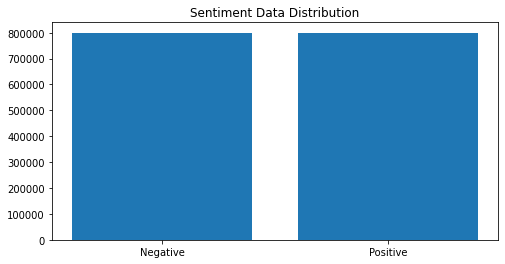

In [6]:
# visualization of the distribution of the two classes
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
# random 10 samples?

#import random
#random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
#df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

## 2b. Text cleanup, tokenization, pre-processing

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
# takes some time ...
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
# fancy plots :)

"""
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
"""

In [21]:
# ps: we have a full train-test set in the downloaded files from http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
#     but we can also just split the loaded and preprocessed data ....

TRAIN_SIZE = 0.8            ### < 80% training dataset, 20% test dataset 
MAX_SEQUENCE_LENGTH = 30    ### <<< cut anything longer than this ...

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=8) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [23]:
train_data.head(10)

,sentiment,text
1595298,Positive,yeah would agree
493942,Negative,faa intentions pilot safety training well reci...
868755,Positive,think time early night 1 2 eps family guy bed
892931,Positive,chicken eat much steak
1596441,Positive,woohoo faith play dublin august excellent feel...
1588349,Positive,gt use windows mobile phones pay
771473,Negative,crazy cat man guy dude turn
60643,Negative,craving bbq bad dont bbq
487457,Negative,busy week ahead already tired
972207,Positive,back home weaverville


In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290492


In [25]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [36]:
# let's see what we have done ...
print(x_train[9])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0     14     29 105502]


In [35]:
# and debug output ...
tokenizer.sequences_to_texts([x_train[9]])

['back home weaverville']

In [37]:
labels = train_data.sentiment.unique().tolist()

In [38]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [42]:
# which label was it?
print(y_train[9])
print("Positive" if y_train[9]>0.5 else "Negative")

[1]
Positive


In [43]:
# GloVe text embedding - fast download 83MB/s

!gdown https://drive.google.com/uc?id=1cPrdK4kMnXDmEh1KQvL39VorE85CglEd
!unzip glove.6B.300d.txt.zip
!gdown https://drive.google.com/uc?id=1tbYUKyZMX-FcmJLz0fU968pztl_XoNrG
!unzip glove.6B.50d.txt.zip
!ls

Downloading...
From: https://drive.google.com/uc?id=1cPrdK4kMnXDmEh1KQvL39VorE85CglEd
To: /content/glove.6B.300d.txt.zip
405MB [00:04, 83.0MB/s]
Archive:  glove.6B.300d.txt.zip
  inflating: glove.6B.300d.txt       
Downloading...
From: https://drive.google.com/uc?id=1tbYUKyZMX-FcmJLz0fU968pztl_XoNrG
To: /content/glove.6B.50d.txt.zip
70.9MB [00:01, 69.9MB/s]
Archive:  glove.6B.50d.txt.zip
  inflating: glove.6B.50d.txt        
glove.6B.300d.txt      sample_data
glove.6B.300d.txt.zip  testdata.manual.2009.06.14.csv
glove.6B.50d.txt       training.1600000.processed.noemoticon.csv
glove.6B.50d.txt.zip   trainingandtestdata.zip


In [ ]:
# GloVe text embedding - original slower source
# ... pretty slow (822MB) ~ 5+ min
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [46]:
#GLOVE_EMB = '/content/glove.6B.300d.txt'
#EMBEDDING_DIM = 300
# lets start with the smaller model
GLOVE_EMB = '/content/glove.6B.50d.txt'
EMBEDDING_DIM = 50

LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [47]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [48]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [49]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# will convert data (the first 30 letters from each tweet) into GloVe representation (50 or 300 dimensional vector)

## 3-4. Simple model ...

In [ ]:
"""
For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification
"""

In [55]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
x = embedding_layer(sequence_input) # lots of frozen weights ...
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x) ## < returns sequences = all intermediate embeddings
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x) ## < returns only the final embedding

"""
x = SpatialDropout1D(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
"""

x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_ours = tf.keras.Model(sequence_input, outputs)

model_ours.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            14524600  
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 64)            29440     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 14,591,289
Trainable params: 66,689
Non-trainable params: 14,524,600
__________________________________________

In [56]:
from tensorflow.keras.optimizers import Adam

model_ours.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])


In [57]:
EPOCHS = 10

# 20 sec ~ with 50d embedding
subset = int( len(x_train) / 8 ) # one quarter of the data
history = model_ours.fit(x_train[:subset], y_train[:subset], batch_size=BATCH_SIZE*2, epochs=EPOCHS,
                    validation_data=(x_test, y_test))


Epoch 1/10
79/79 [==============================] - 25s 257ms/step - loss: 0.6598 - accuracy: 0.6052 - val_loss: 0.6019 - val_accuracy: 0.6722
Epoch 2/10
79/79 [==============================] - 20s 252ms/step - loss: 0.6049 - accuracy: 0.6677 - val_loss: 0.5807 - val_accuracy: 0.6904
Epoch 3/10
79/79 [==============================] - 20s 250ms/step - loss: 0.5858 - accuracy: 0.6835 - val_loss: 0.5684 - val_accuracy: 0.7002
Epoch 4/10
79/79 [==============================] - 20s 248ms/step - loss: 0.5709 - accuracy: 0.6978 - val_loss: 0.5585 - val_accuracy: 0.7089
Epoch 5/10
79/79 [==============================] - 19s 247ms/step - loss: 0.5618 - accuracy: 0.7051 - val_loss: 0.5470 - val_accuracy: 0.7173
Epoch 6/10
79/79 [==============================] - 19s 246ms/step - loss: 0.5548 - accuracy: 0.7115 - val_loss: 0.5401 - val_accuracy: 0.7224
Epoch 7/10
79/79 [==============================] - 19s 247ms/step - loss: 0.5479 - accuracy: 0.7155 - val_loss: 0.5360 - val_accuracy: 0.7255

### Training plots:

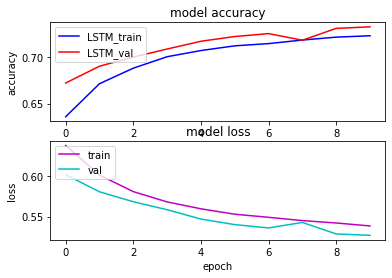

In [58]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [59]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

scores = model_ours.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 2s 64ms/step


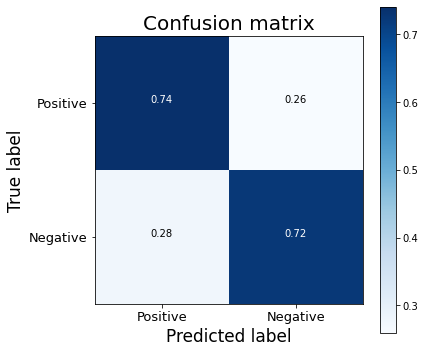

In [61]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [62]:
# visualization of these metrics - https://en.wikipedia.org/wiki/Precision_and_recall
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.73      0.74      0.73    160032
    Positive       0.74      0.72      0.73    159968

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



### Interacting with the trained model

In [69]:
custom_texts = [ "The universe is a good place" ,
                 "The universe is a bad place"
          ]

x_custom = pad_sequences(tokenizer.texts_to_sequences(custom_texts),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("^ this gets represented as:", x_custom)

^ this gets represented as: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2750
     1  302]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2750
    49  302]]


In [70]:
scores_custom = model_ours.predict(x_custom, verbose=1, batch_size=10000)
print("model prediction:", scores_custom)
y_pred_1d_custom = [decode_sentiment(score) for score in scores_custom]
print("decoded:", y_pred_1d_custom)

1/1 [==============================] - 0s 25ms/step
model prediction: [[0.909293  ]
 [0.11673109]]
decoded: ['Positive', 'Negative']




> Basic function works, can we do something better? Yeah, better model!



## 3-4. More complicated model

In [ ]:
"""
For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification
"""
True

In [84]:
# lets use the more complex embedding

GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300

#GLOVE_EMB = '/content/glove.6B.50d.txt'
#EMBEDDING_DIM = 50

LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [85]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [86]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [87]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# will convert data (the first 30 letters from each tweet) into GloVe representation (50 or 300 dimensional vector)

In [88]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x) ### < more fancy LSTM!
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)              ### < more dropouts around
x = Dense(512, activation='relu')(x)    ### < larger intermediate feature size ...
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           87147600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [89]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

## and we add automatic learning rate adjustment (reduce LR on plateau)
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


In [74]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

# CPU -> one epoch takes about 20 minutes ...
# CPU -> one epoch takes about 2 minutes ...

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [90]:
# for presentation purposes we might use some speed up hacks ... 
# ... like using only a portion of the dataset

subset =  int( len(x_train) / 4 ) # from 1 280 000
history = model.fit(x_train[:subset], y_train[:subset], batch_size=2*BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

# cca 41 sec with 300d vectors

Epoch 1/10
157/157 [==============================] - 46s 269ms/step - loss: 0.6003 - accuracy: 0.6654 - val_loss: 0.5171 - val_accuracy: 0.7415
Epoch 2/10
157/157 [==============================] - 41s 260ms/step - loss: 0.5216 - accuracy: 0.7380 - val_loss: 0.5015 - val_accuracy: 0.7511
Epoch 3/10
157/157 [==============================] - 41s 264ms/step - loss: 0.5026 - accuracy: 0.7514 - val_loss: 0.4926 - val_accuracy: 0.7582
Epoch 4/10
157/157 [==============================] - 41s 262ms/step - loss: 0.4909 - accuracy: 0.7602 - val_loss: 0.4905 - val_accuracy: 0.7589
Epoch 5/10
157/157 [==============================] - 41s 259ms/step - loss: 0.4832 - accuracy: 0.7647 - val_loss: 0.4869 - val_accuracy: 0.7623
Epoch 6/10
157/157 [==============================] - 41s 264ms/step - loss: 0.4743 - accuracy: 0.7708 - val_loss: 0.4857 - val_accuracy: 0.7632
Epoch 7/10
157/157 [==============================] - 40s 256ms/step - loss: 0.4665 - accuracy: 0.7754 - val_loss: 0.4882 - val_ac

In [ ]:
#history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

### Training plots:

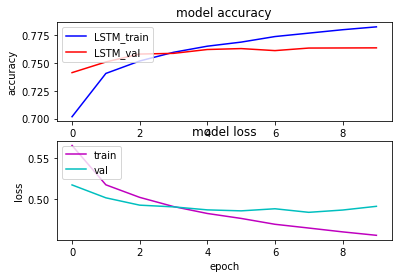

In [91]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [92]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 5s 148ms/step


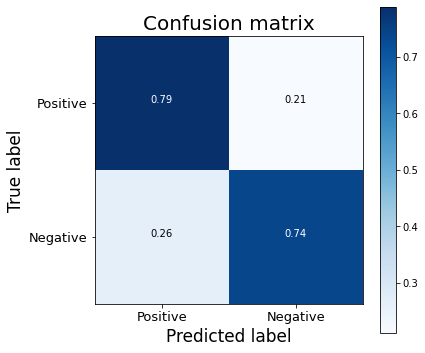

In [93]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()


In [94]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.75      0.79      0.77    160032
    Positive       0.78      0.74      0.76    159968

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



### Interacting with the trained model

In [95]:
custom_texts = [ "The universe is a good place" ,
                 "The universe is a bad place"
          ]

x_custom = pad_sequences(tokenizer.texts_to_sequences(custom_texts),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("^ this gets represented as:", x_custom)

^ this gets represented as: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2750
     1  302]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2750
    49  302]]


In [96]:
scores_custom = model.predict(x_custom, verbose=1, batch_size=10000)
print("model prediction:", scores_custom)
y_pred_1d_custom = [decode_sentiment(score) for score in scores_custom]
print("decoded:", y_pred_1d_custom)

1/1 [==============================] - 0s 392ms/step
model prediction: [[0.8874308 ]
 [0.08835886]]
decoded: ['Positive', 'Negative']




> PS: using the whole dataset would also help ....



# Possible tasks:



1.   Try **interacting** with the trained model. Is there something that would **break** it?
2.   Could you write **your own function** that will ask the user for input (for example via the python "input()" function) and **use the pretrained model** to infer the sentiment of it?
3.   Could you do the same but with loading a saved .h5 model file - aka that it would work as a **separate piece of code** later for some other project (imagine this being a single box in your own custom pipeline).

